Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Preview of Dataset:
   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1               1       -0.0007       -0.0004         100.0   
1            1               2        0.0019       -0.0003         100.0   
2            1               3       -0.0043        0.0003         100.0   
3            1               4        0.0007        0.0000         100.0   
4            1               5       -0.0019       -0.0002         100.0   

   sensor_measurement_1  sensor_measurement_2  sensor_measurement_3  \
0                518.67                641.82               1589.70   
1                518.67                642.15               1591.82   
2                518.67                642.35               1587.99   
3                518.67                642.35               1582.79   
4                518.67                

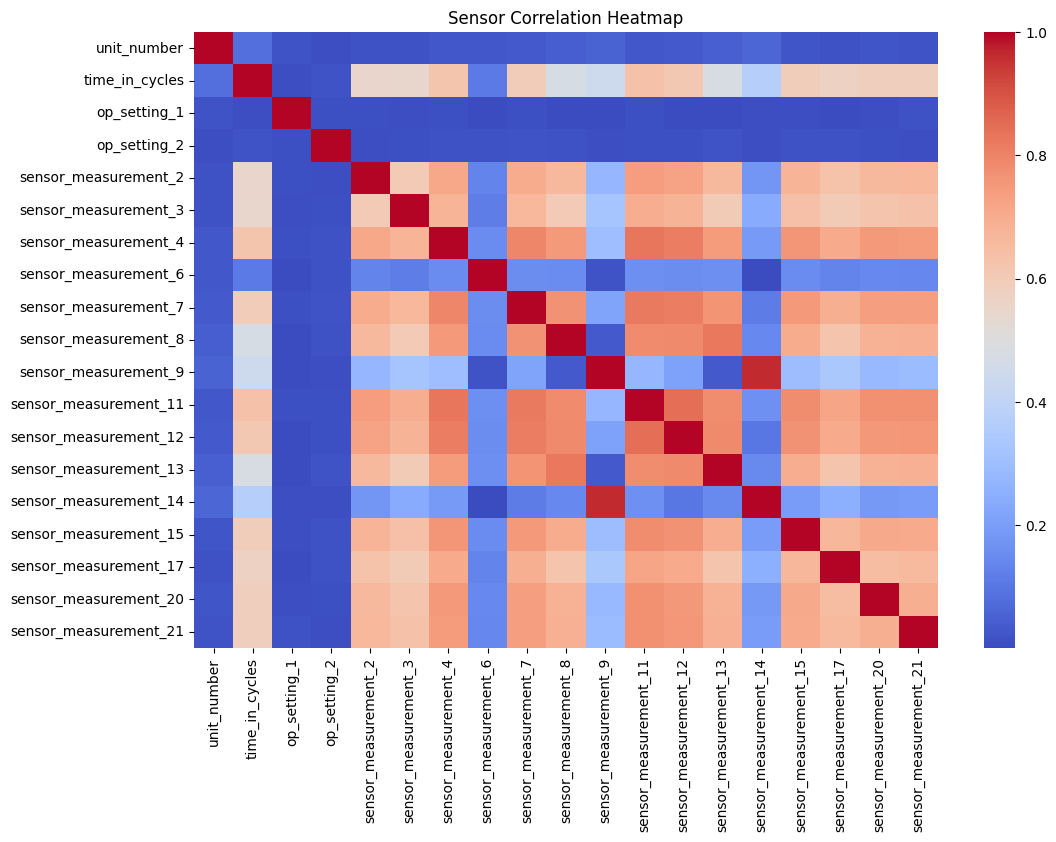

Cleaned dataset saved to: /content/drive/MyDrive/predictive_maintenance/cleaned_train_FD001.csv


In [ ]:
### -----------------------------------------------------------------------###
# --- Data Understanding & Cleaning
### -----------------------------------------------------------------------###

# -------- 1. Imports --------------
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# let Create path to save plot in PNG form
if not os.path.exists('../results'):
    os.makedirs('../results')
# ------2. Mount Google Drive & Define Paths ------
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/predictive_maintenance/data'
train_fd001_path = os.path.join(data_path, 'train_FD001.txt')

# --- 3. Decide column names ---
col_names = [
    'unit_number', 'time_in_cycles',                    # taking ID of engine as unit_number and current cycle of the engine as time_in_cycles.
    'op_setting_1', 'op_setting_2', 'op_setting_3'      # operational settings like temperature etc.
] + [f'sensor_measurement_{i}' for i in range(1, 22)]   # and sensor measurement as readings from different sensors over time.

# --- 4.To Read the file ---
train_df = pd.read_csv(train_fd001_path, sep=' ', header=None)

# Cleaning up empty columns
train_df = train_df.dropna(axis=1, how='all')    # this will remove columns that are completely empty, which sometimes occur in CMAPSS datasets.

# Next Adding the column names
train_df.columns = col_names

# ---5. EDA- Exploratory Data Analysis ---

# Using EDA Analysis to undersatdn the data structure & Detect missing or invalid values
# Preview first few rows
print("Preview of Dataset:")
print(train_df.head())

# Number of rows and columns
print("Shape:", train_df.shape)

# Missing values check (should be zero in CMAPSS)
print("missing Values:")
print(train_df.isnull().sum())

# Column info and datatypes
print("Column INFO:")
print(train_df.info())   # this info will show the data types of columns and non-null counts, useful to detect issues.

# Statistics for all numeric columns
print("Basic Statistics:")
print(train_df.describe())  # This will provide mean,std,min,max,quartiles for all numeric columns

# Stats for only op_setting columns
print("Operating Setting Summary:")
print(train_df[['op_setting_1', 'op_setting_2', 'op_setting_3']].describe())

# Stats for only sensor_measurement columns
sensor_cols = [col for col in train_df.columns if 'sensor_measurement' in col]
print("Sensor Measurement Summary:")
print(train_df[sensor_cols].describe())  # displaying stats for sensor measurements is not cumpolsory but will help in detecting outliers.

# Number of engines in training dataset
print("Number of engines:", train_df['unit_number'].nunique())

# Cycles per engine - distribution of engine lifespans
print("Engine LIfespan Stats:")
print(train_df.groupby('unit_number')['time_in_cycles'].max().describe())

# ---6.  Data Cleaning ---

# Data cleaning removes irrelevant or constant features & remove redundancy importantly
# Identify and drop constant sensors (zero variance)
constant_columns = [col for col in train_df.columns if train_df[col].nunique() == 1]
print("Constant columns:", constant_columns)

train_df = train_df.drop(columns=constant_columns)
print("Shape after dropping constant sensors:", train_df.shape)

# let Compute correlation for numeric sensor columns
numeric_cols = train_df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = train_df[numeric_cols].corr().abs()

# Keeping only the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify highly correlated columns (threshold > 0.9)
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
print("Highly correlated columns to drop:", to_drop)

# optional but beneficial: Drop highly correlated columns
train_df = train_df.drop(columns=to_drop)
print("Shape after dropping highly correlated sensors:", train_df.shape)


# ---7. Plot of heatmap (before dropping highly correlated columns) ---
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title("Sensor Correlation Heatmap")
plt.savefig('../results/correlation_heatmap.png', dpi=300)
plt.show()

# --- 8. Save the cleaned dataset for use ---
cleaned_data_path = '/content/drive/MyDrive/predictive_maintenance/cleaned_train_FD001.csv'

train_df.to_csv(cleaned_data_path, index=False)
print(f"Cleaned dataset saved to: {cleaned_data_path}")

# ===================================================== #
# Summary for the Day

# In this study we Check the dataset,
# explore how sensors and engines behave,
# remove useless or repeated columns,
# and save a clean version for modeling.
# ===================================================== #

